# Projet LU3IN114  
___  

## L'équipe
___  

**_Matthieu Dartois - 21113417_**  
**_William Rosewarn - 21102208_**

## Résumé
___  

Ce projet de cours porte sur la prédiction de la note d'un film en fonction de différents paramètres tels que le budget, les acteurs jouant dans le film, le studio de production ou encore la durée du film.  
  
Pour ce faire, nous avons utilisé différents modèles d'apprentissage supervisé sur un dataset issu de Kaggle ([Lien du dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata))  

Dans la suite de ce notebook, nous détaillerons notre procédure.

### 1. On importe les bilbiothèques nécessaires

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ast
import utils

import time

### 2. Opérations de base : chargement des données et affichage de la structure et des premières valeurs

In [3]:
data = pd.read_csv('tmdb_5000_movies.csv')

# On affiche la première ligne du fichier
print(data.head(1))

# On affiche la structure du fichier 
print(data.info())

      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                      homepage     id  \
0  http://www.avatarmovie.com/  19995   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   

                       tagline   title 

### 3. On nettoie les données que nous avons : les colonnes inutiles

In [4]:
data = data.drop(columns=['homepage', 'id', 'overview', 'status', 'tagline', 'title', 'popularity', 'revenue'])

# Appliquer la fonction aux colonnes cibles
columns_to_clean = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages']
for column in columns_to_clean:
    data[column] = data[column].apply(utils.extract_names)

#On affiche de nouveau le fichier update
print(data.head(1))

      budget                                         genres  \
0  237000000  [Action, Adventure, Fantasy, Science Fiction]   

                                            keywords original_language  \
0  [culture clash, future, space war, space colon...                en   

  original_title                               production_companies  \
0         Avatar  [Ingenious Film Partners, Twentieth Century Fo...   

                         production_countries release_date  runtime  \
0  [United States of America, United Kingdom]   2009-12-10    162.0   

     spoken_languages  vote_average  vote_count  
0  [English, Español]           7.2       11800  


### 4. On prépare les données pour l'analyse et la modélisation en utilisant TfidVectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combiner les colonnes textuelles en une seule colonne
data['text'] = data['original_title'] + ' ' + \
               data['genres'].apply(' '.join) + ' ' + \
               data['keywords'].apply(' '.join) + ' ' + \
               data['production_companies'].apply(' '.join) + ' ' + \
               data['production_countries'].apply(' '.join) + ' ' + \
               data['spoken_languages'].apply(' '.join)

data['text'] = data['text'].fillna('')

# init de TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=100, max_df=0.5)

start_time = time.time()
X_tfidf = vectorizer.fit_transform(data['text'])
end_time = time.time()

print(f"Temps de vectorisation: {end_time - start_time} secondes")

# on transforme le tout en Dataframe pour rendre les opérations dessus et l'affichage plus simple
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_df.head())

Temps de vectorisation: 0.08022165298461914 secondes
     action  adventure  aftercreditsstinger     alien  american       and  \
0  0.089589   0.103595             0.000000  0.353693       0.0  0.127112   
1  0.164590   0.190320             0.296004  0.000000       0.0  0.000000   
2  0.154861   0.179070             0.000000  0.000000       0.0  0.000000   
3  0.205516   0.000000             0.000000  0.000000       0.0  0.000000   
4  0.150619   0.174165             0.000000  0.594633       0.0  0.213703   

   animation  australia     based      bros  ...   to  twentieth  universal  \
0        0.0        0.0  0.000000  0.000000  ...  0.0   0.149944        0.0   
1        0.0        0.0  0.000000  0.000000  ...  0.0   0.000000        0.0   
2        0.0        0.0  0.216494  0.000000  ...  0.0   0.000000        0.0   
3        0.0        0.0  0.000000  0.310267  ...  0.0   0.000000        0.0   
4        0.0        0.0  0.210564  0.000000  ...  0.0   0.000000        0.0   

   violen

### 5. On entraine les modèles et on récupère leur taux d'erreurs

#### On sépare les ensembles de tests et d'entrainement

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# on ajoute des features
features = pd.concat([data[['budget', 'runtime']], tfidf_df], axis=1)

# ce qu'on cherche à obetnir
target = data['vote_average']

# on divise les données en test et train
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


In [7]:
X_train

,budget,runtime,action,adventure,aftercreditsstinger,alien,american,and,animation,australia,...,to,twentieth,universal,violence,walt,war,warner,woman,world,york
4687,0,86.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.400425,0.0,0.000000
2951,11000000,105.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.393409
4071,2000000,115.0,0.155278,0.179553,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000
4579,400000,91.0,0.000000,0.215509,0.0,0.0,0.0,0.264432,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000
2197,20000000,106.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0,90.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000
466,80000000,96.0,0.192240,0.222293,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.28976,0.000000,0.0,0.000000
3092,10000000,96.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000
3772,4000000,90.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.320086


#### On entraine les modèles sur les jeux de données

Vérification des NaN 0 0
Forest MSE : 1.17857043782388
Linear Regression MSE: 1.1342809656837485
SVR MSE: 1.4837866387908192
Gradient Boosting Regressor MSE: 1.1339337047110212
XGBoost Regressor MSE: 1.2134639599017674
KNN Regressor MSE: 1.3549094693028096


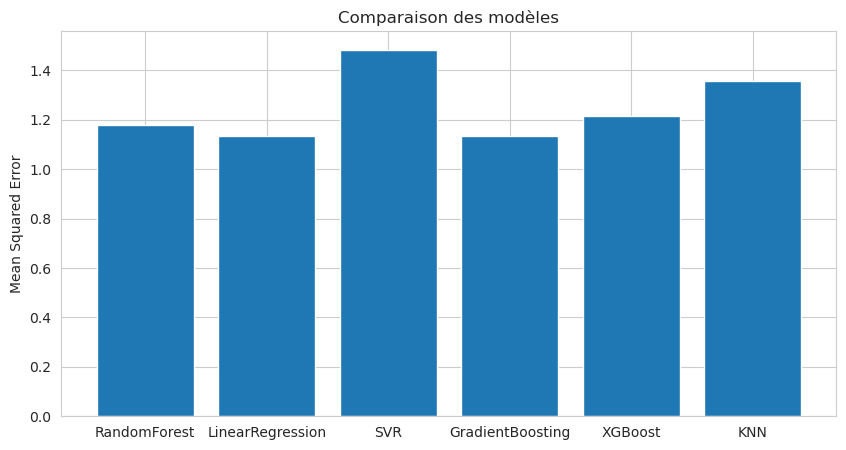

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer

# Imputer pour remplacer les NaN par la médiane
imputer = SimpleImputer(strategy='median')

# Appliquer l'imputer sur les features
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Vérification des NaN
print("Vérification des NaN", np.isnan(X_train_imputed).sum(), np.isnan(X_test_imputed).sum())

# RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred_forest = model.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f"Forest MSE : {mse_forest}")

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_imputed, y_train)
y_pred_linear = linear_model.predict(X_test_imputed)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Linear Regression MSE: {mse_linear}")

# Support Vector Regressor (SVR)
svr_model = SVR()
svr_model.fit(X_train_imputed, y_train)
y_pred_svr = svr_model.predict(X_test_imputed)
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"SVR MSE: {mse_svr}")

# Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor()
gbr_model.fit(X_train_imputed, y_train)
y_pred_gbr = gbr_model.predict(X_test_imputed)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
print(f"Gradient Boosting Regressor MSE: {mse_gbr}")

# XGBoost Regressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train_imputed, y_train)
y_pred_xgb = xgb_model.predict(X_test_imputed)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Regressor MSE: {mse_xgb}")

# K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_imputed, y_train)
y_pred_knn = knn_model.predict(X_test_imputed)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print(f"KNN Regressor MSE: {mse_knn}")

# Comparer les MSE
mse_scores = {
    'RandomForest': mse_forest,
    'LinearRegression': mse_linear,
    'SVR': mse_svr,
    'GradientBoosting': mse_gbr,
    'XGBoost': mse_xgb,
    'KNN': mse_knn
}

plt.figure(figsize=(10, 5))
plt.bar(mse_scores.keys(), mse_scores.values())
plt.ylabel('Mean Squared Error')
plt.title('Comparaison des modèles')
plt.show()

### 6. On utilise le modèle avec le plus faible taux d'erreurs pour faire des tests et prédire les notes des films

In [28]:
from prediction import predict_new_film
new_film_example = {
    'budget': 150000000000,
    'genres': ['Action', 'Adventure'],
    'keywords': ['hero', 'quest'],
    'production_companies': ['Marvel Studios'],
    'production_countries': ['United States of America'],
    'spoken_languages': ['Français'],
    'original_title': 'New Hero Quest',
    'runtime': 120
}

# Prédire la note du nouveau film
predicted_vote = predict_new_film(new_film_example, vectorizer, gbr_model, imputer)
print(f"Prédiction de la note (vote_average) pour le nouveau film : {predicted_vote}")

Prédiction de la note (vote_average) pour le nouveau film : 6.158674620956015
